<a href="https://colab.research.google.com/github/BIRAN/python_related/blob/master/W1_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0b1

In [0]:
import tensorflow as tf
print(tf.__version__)

# EXPECTED OUTPUT
# 2.0.0-beta1 (or later)

2.0.0-beta1


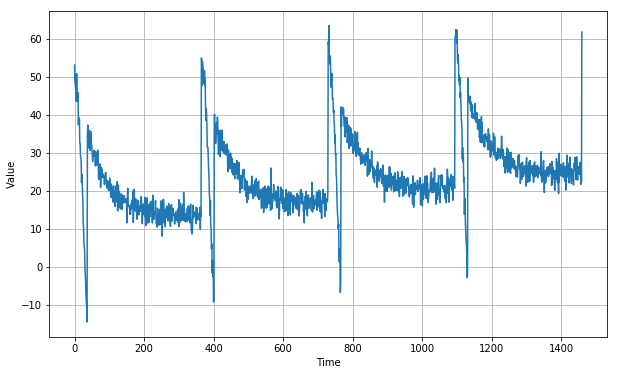

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

# Training and Validation Split
Now that we have the time series, let's split it so we can start forecasting.

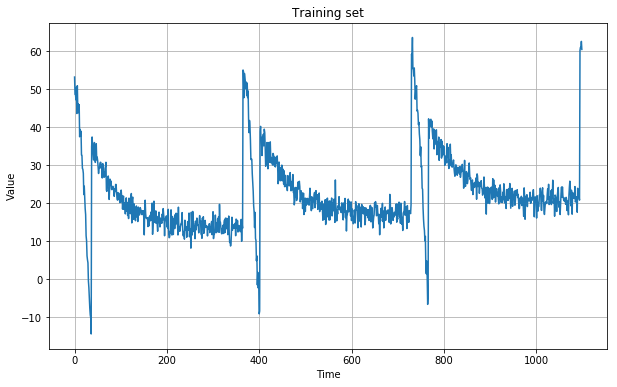

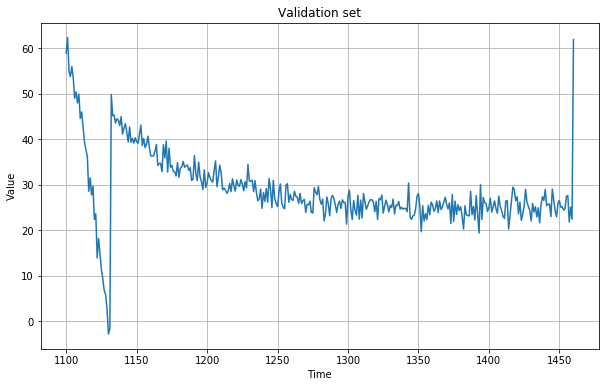

In [0]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plt.title('Training set')
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plt.title('Validation set')
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Model 1: Naive Forecast 
It is simply method, just predict it as   $ Forecast(t) = x(t-1)$.

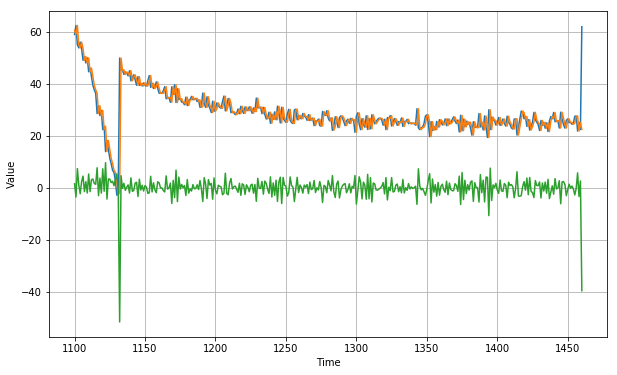

In [0]:
# No need to write it for training set

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plot_series(time_valid, naive_forecast - x_valid)

In [0]:
x_valid[0] == naive_forecast[1]

# it is easy to see x(t-1) = forecast(t)

True

Let's zoom in on the start of the validation period:

You can see that the naive forecast lags 1 step behind the time series.

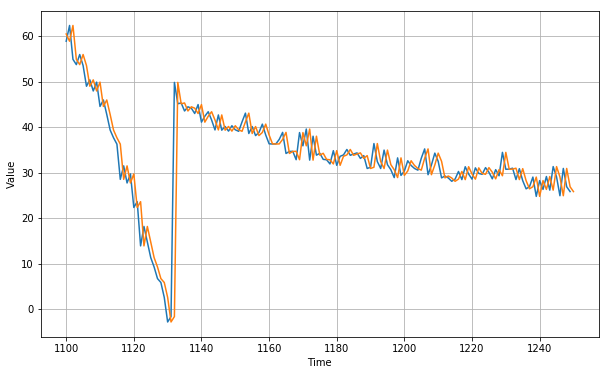

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=151)

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [0]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

20.012127
2.5251672


# Model 2: Moving Average
The previous one is our baseline model. Now let's try a moving average:

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

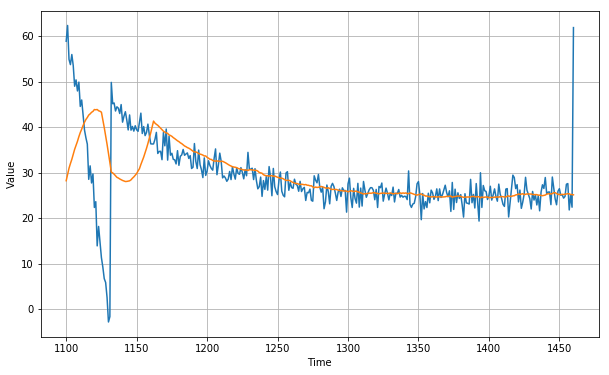

In [0]:
# give it a look at the graph (how it looks)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [0]:
# show MSE MAE
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.9585
# 4.3191605

65.9585
4.3191605


That's worse than naive forecast! For several reasons, I wrote the following code to find the best window size on it. Let's have a look.

In [0]:
best_MSE_window_size = keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
best_MAE_window_size = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
tmp_MSE_window_size = 0
tmp_MAE_window_size = 0
best_MSE_window = 0
best_MAE_window = 0

for window_size in range(1,30):
  moving_avg = moving_average_forecast(series, window_size)[split_time-window_size:]
  tmp_MSE_window_size = keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
  tmp_MAE_window_size = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
  if tmp_MSE_window_size < best_MSE_window_size:
    best_MSE_window_size = tmp_MSE_window_size
    best_MSE_window = window_size
  if tmp_MAE_window_size < best_MAE_window_size:
    best_MAE_window_size = tmp_MAE_window_size
    best_MAE_window = window_size
print('best window size of MSE is %i, and corresponding MSE is %f' % (best_MSE_window, best_MSE_window_size))
print('best window size of MAE is %i, and corresponding MAE is %f' % (best_MAE_window, best_MAE_window_size))

best window size of MSE is 2, and corresponding MSE is 19.145908
best window size of MAE is 2, and corresponding MAE is 2.257431


There are many other reasons. The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

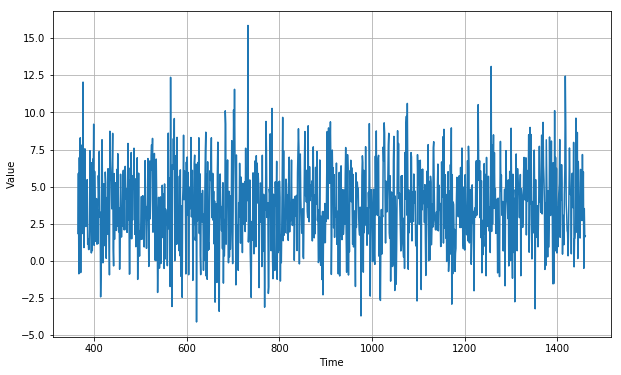

In [0]:
diff_series = (series[365:] - series[:-365]) # use differencing on seasonality
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

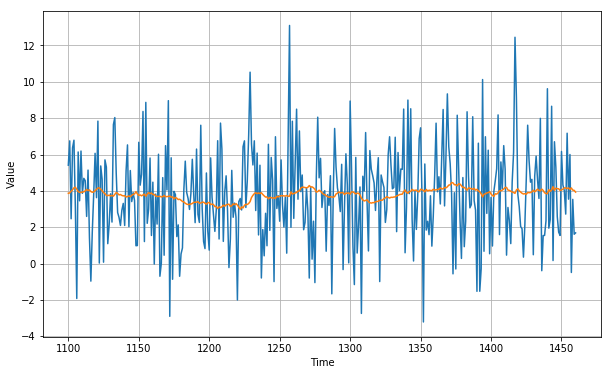

In [0]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

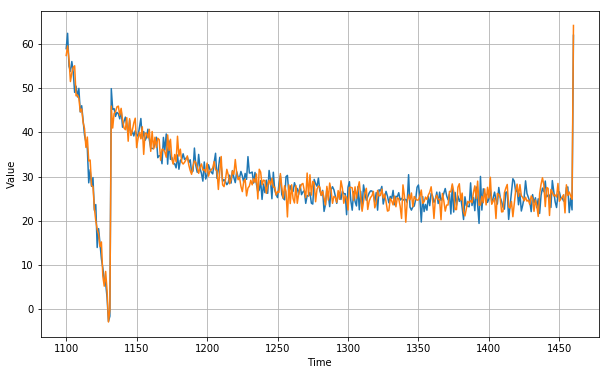

In [0]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

7.1276207
2.1154194


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

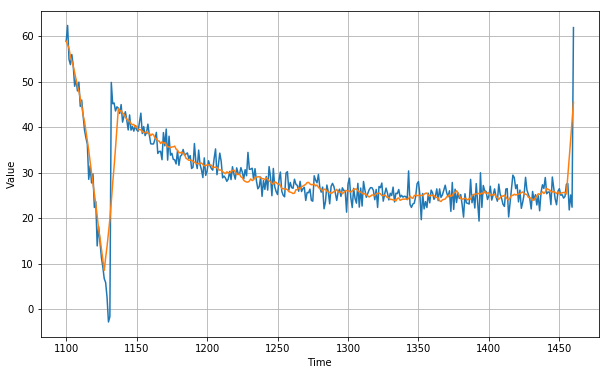

In [0]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 360 - 10:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

12.90712
2.1032932


In the Moving Average model, we have a lot of parameters to tune. 

# Model 3: ARIMA
ARIMA model is the combination of AR and MA model with Differencing. The important of using ARIMA(p,d,q) is based on finding p,d,q.
We can decide p,d,q based on Autocorrelation graph and PACF graph. The value of d depends on the number of differencing it takes to make the time series data to be stationary (check [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)). 

In [0]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(2, 0, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# This part built ARIMA, not optimal of course.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1461
Model:                     ARMA(2, 0)   Log Likelihood               -4173.363
Method:                       css-mle   S.D. of innovations              4.208
Date:                Sat, 03 Aug 2019   AIC                           8354.725
Time:                        19:41:08   BIC                           8375.873
Sample:                             0   HQIC                          8362.614
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.3296      1.415     17.195      0.000      21.556      27.103
ar.L1.y        0.7390      0.027     27.856      0.000       0.687       0.791
ar.L2.y        0.1838      0.027      6.912      0.0

In [0]:
!pip install pmdarima

  Using cached https://files.pythonhosted.org/packages/28/1d/1cf4dd83f3c129774343a642d4d42f9ad727d0d02f757893ea9c67514d78/pmdarima-1.2.1-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 24.8MB 42.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0


In [0]:
# Auto decision on ARIMA(p,d,q)
import pmdarima as pm
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=8355.012, BIC=8376.159, Fit time=0.226 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=10788.402, BIC=10798.976, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=8399.733, BIC=8415.593, Fit time=0.175 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=9708.996, BIC=9724.857, Fit time=0.193 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=8356.434, BIC=8382.869, Fit time=0.448 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=8356.512, BIC=8382.946, Fit time=0.405 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=8357.684, BIC=8389.405, Fit time=0.979 seconds
Total fit time: 2.473 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1461
Model:               SARIMAX(1, 0, 1)   Log Likelihood       

In [0]:
# Auto decision on SARIMA(p,d,q)(P,D,Q)
smodel = pm.auto_arima(series, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=365,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

In [0]:
# graph decision on PACF
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

autocorrelation_plot(series)
plot_pacf(series, lags =20)


# Some websites to check

[ARIMA](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

[Time series](https://www.machinelearningplus.com/category/time-series/)

[SARIMAX: Introduction](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)



# Demo: Sunspots



In [0]:
from google.colab import files
uploaded = files.upload()

Saving Sunspots.csv to Sunspots.csv


In [0]:
import pandas as pd
df = pd.read_csv("Sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

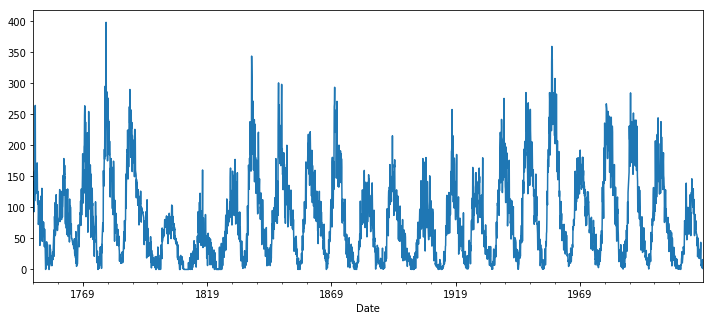

In [0]:
series.plot(figsize=(12, 5))

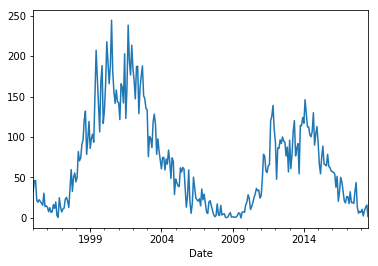

In [0]:
series["1995-01-01":].plot()

[0, 100, -50, 50]

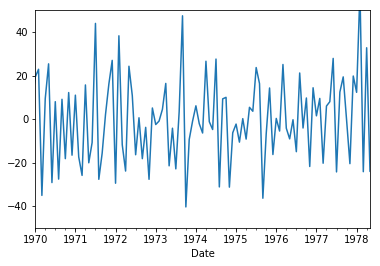

In [0]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

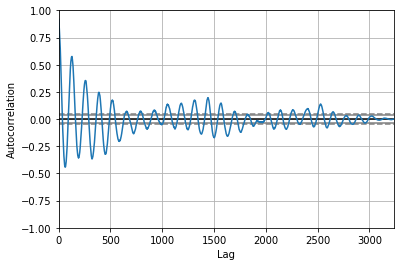

In [0]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

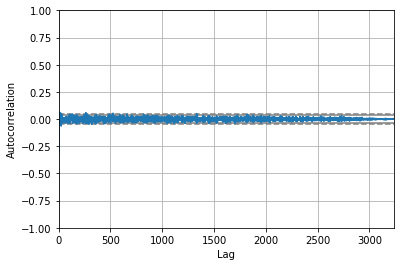

In [0]:
autocorrelation_plot(series.diff(1)[1:])

[0, 500, -0.1, 0.1]

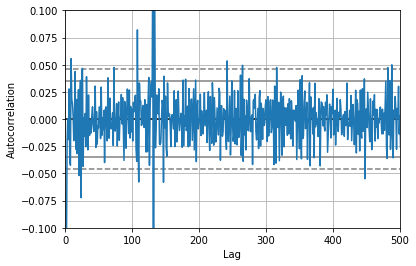

In [0]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

[0, 50, -0.1, 0.1]

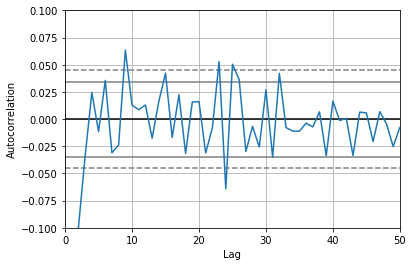

In [0]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [0]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9173241872367174,
 0.8847544206843755,
 0.868599123137202,
 0.8579945644357173,
 0.8433856340533112,
 0.8306731729540908,
 0.8121138897370149,
 0.7986059878541056,
 0.7890399489112041,
 0.7689560950230403,
 0.7474788716472306,
 0.7238791854325145,
 0.6980482665379879,
 0.6751408790165827,
 0.6495670049994807,
 0.6170092179855494,
 0.5872028494447984,
 0.5537209387574675,
 0.5254318210710769,
 0.49453915657274083,
 0.4609225001523783,
 0.4325062022560218,
 0.4054329883610248,
 0.36959289593532285,
 0.3443549899460771,
 0.3106967622634346,
 0.2711411693399097,
 0.23646964014948227,
 0.20297806535027266,
 0.17379537689762675,
 0.14010793836897956,
 0.11227445177460688,
 0.07751076852866026,
 0.044054957960606746,
 0.012510863120931944,
 -0.017282156504566333,
 -0.046433352357512225,
 -0.07440203532677167,
 -0.10339501296715731,
 -0.12680806162977237,
 -0.1530928264197593,
 -0.17906178224521474,
 -0.20506772757843425,
 -0.22530867957591932,
 -0.2466587000579558,
 -0.26904607854968615,
 